In [31]:
# Cell [X]: Import libraries for ML
!pip install scikit-learn

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
import pandas as pd
import numpy as np



[notice] A new release of pip is available: 23.1.2 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


                                              0.0/10.7 MB ? eta -:--:--
                                              0.0/10.7 MB ? eta -:--:--
                                             0.0/10.7 MB 435.7 kB/s eta 0:00:25
                                             0.1/10.7 MB 465.5 kB/s eta 0:00:23
                                             0.1/10.7 MB 573.4 kB/s eta 0:00:19
                                             0.1/10.7 MB 573.4 kB/s eta 0:00:19
                                             0.1/10.7 MB 573.4 kB/s eta 0:00:19
                                             0.2/10.7 MB 620.6 kB/s eta 0:00:17
                                             0.2/10.7 MB 620.6 kB/s eta 0:00:17
                                             0.2/10.7 MB 620.6 kB/s eta 0:00:17
                                             0.2/10.7 MB 620.6 kB/s eta 0:00:17
                                             0.2/10.7 MB 458.5 kB/s eta 0:00:23
     -                                       0.4/10.7 MB

In [42]:
with open("user-wallet-transactions.json", "r") as f:
    raw_data = json.load(f)

# Flatten raw data
txs = []
for tx in raw_data:
    txs.append({
        "wallet": tx["userWallet"],
        "action": tx["action"],
        "timestamp": tx["timestamp"],
        "amount": float(tx["actionData"].get("amount", 0)),
        "asset": tx["actionData"].get("assetSymbol"),
        "price_usd": float(tx["actionData"].get("assetPriceUSD", 1.0))
    })

df = pd.DataFrame(txs)
df["timestamp"] = pd.to_datetime(df["timestamp"], unit="s")
df.head(100)


,wallet,action,timestamp,amount,asset,price_usd
0,0x00000000001accfa9cef68cf5371a23025b6d4b6,deposit,2021-08-17 05:29:26,2.000000e+09,USDC,0.993832
1,0x000000000051d07a4fb3bd10121a343d85818da6,deposit,2021-05-20 15:36:53,1.450000e+20,WMATIC,1.970307
2,0x000000000096026fb41fc39f9875d164bd82e2dc,deposit,2021-07-24 09:28:33,1.000000e+15,WMATIC,0.922377
3,0x000000000096026fb41fc39f9875d164bd82e2dc,deposit,2021-07-31 23:15:18,4.000000e+15,WMATIC,1.057483
4,0x0000000000e189dd664b9ab08a33c4839953852c,redeemunderlying,2021-04-19 15:25:07,5.015480e+05,USDC,1.002130
...,...,...,...,...,...,...
95,0x0000000002032370b971dabd36d72f3e5a7bf1ee,deposit,2021-05-21 10:06:56,4.000000e+09,USDC,1.003710
96,0x0000000002032370b971dabd36d72f3e5a7bf1ee,repay,2021-05-21 11:32:19,5.729354e+10,USDT,1.001623
97,0x0000000002032370b971dabd36d72f3e5a7bf1ee,redeemunderlying,2021-05-21 11:33:05,3.000000e+10,USDC,0.996942
98,0x0000000002032370b971dabd36d72f3e5a7bf1ee,deposit,2021-05-21 11:37:19,6.173737e+09,USDC,1.004224


In [43]:
import numpy as np

features_list = []

for wallet, group in df.groupby("wallet"):
    group = group.sort_values("timestamp")
    total_tx = len(group)

    deposits = group[group["action"] == "deposit"]["amount"].sum()
    borrows = group[group["action"] == "borrow"]["amount"].sum()
    repays = group[group["action"] == "repay"]["amount"].sum()
    redeems = group[group["action"] == "redeemunderlying"]["amount"].sum()
    liquidations = group[group["action"] == "liquidationcall"].shape[0]
    tx_types = group["action"].nunique()
    active_days = max(1, (group["timestamp"].max() - group["timestamp"].min()).days)

    repay_ratio = repays / borrows if borrows > 0 else 1
    borrow_deposit_ratio = borrows / deposits if deposits > 0 else 0
    is_bot_like = total_tx > 100 and tx_types < 3

    # Rule-based pseudo score
    score = 500
    score += 200 * min(repay_ratio, 1)
    score -= 100 if borrow_deposit_ratio > 1 else 0
    score -= 150 if liquidations > 0 else 0
    score += 100 if tx_types >= 4 else 0
    score -= 50 if is_bot_like else 0
    score = int(np.clip(score, 0, 1000))

    features_list.append({
        "wallet": wallet,
        "total_tx": total_tx,
        "deposits": deposits,
        "borrows": borrows,
        "repays": repays,
        "redeems": redeems,
        "liquidations": liquidations,
        "tx_types": tx_types,
        "active_days": active_days,
        "repay_ratio": repay_ratio,
        "borrow_deposit_ratio": borrow_deposit_ratio,
        "is_bot_like": int(is_bot_like),
        "pseudo_score": score
    })


In [44]:
features_df = pd.DataFrame(features_list)
features_df.head()


,wallet,total_tx,deposits,borrows,repays,redeems,liquidations,tx_types,active_days,repay_ratio,borrow_deposit_ratio,is_bot_like,pseudo_score
0,0x00000000001accfa9cef68cf5371a23025b6d4b6,1,2.000000e+09,0.000000e+00,0.000000e+00,0.000000e+00,0,1,1,1.000000e+00,0.000000,0,700
1,0x000000000051d07a4fb3bd10121a343d85818da6,1,1.450000e+20,0.000000e+00,0.000000e+00,0.000000e+00,0,1,1,1.000000e+00,0.000000,0,700
2,0x000000000096026fb41fc39f9875d164bd82e2dc,2,5.000000e+15,0.000000e+00,0.000000e+00,0.000000e+00,0,1,7,1.000000e+00,0.000000,0,700
3,0x0000000000e189dd664b9ab08a33c4839953852c,17,0.000000e+00,0.000000e+00,0.000000e+00,4.835297e+18,0,1,129,1.000000e+00,0.000000,0,700
4,0x0000000002032370b971dabd36d72f3e5a7bf1ee,399,9.459366e+22,3.946000e+22,7.002457e+10,3.946556e+22,0,4,132,1.774571e-12,0.417153,0,600


In [45]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error

X = features_df.drop(columns=["wallet", "pseudo_score"])
y = features_df["pseudo_score"]

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

y_pred = rf_model.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
print(f"✅ Model trained. MAE: {mae:.2f}")


✅ Model trained. MAE: 0.56


In [46]:
features_df["rf_score"] = rf_model.predict(X).clip(0, 1000).round().astype(int)

features_df[["wallet", "rf_score"]].rename(columns={"rf_score": "score"}).to_json(
    "wallet_scores_rf.json", orient="records", indent=2
)

print("✅ Saved Random Forest scores to wallet_scores_rf.json")


✅ Saved Random Forest scores to wallet_scores_rf.json


📊 Summary Statistics (RF Scores):
count    3497.000000
mean      677.084930
std        95.947762
min       276.000000
25%       700.000000
50%       700.000000
75%       700.000000
max       800.000000
Name: score, dtype: float64


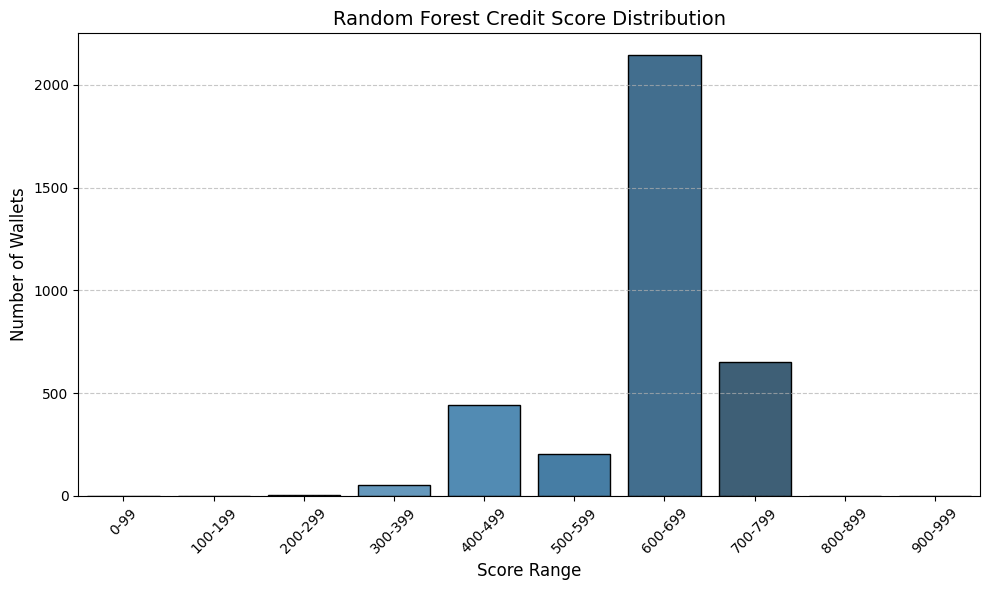

In [47]:
import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load Random Forest–based wallet scores from JSON file
with open("wallet_scores_rf.json", "r") as f:
    scores = json.load(f)

# Convert to DataFrame
df = pd.DataFrame(scores)

# Summary statistics
print("📊 Summary Statistics (RF Scores):")
print(df["score"].describe())

# Define score ranges (0–100, 100–200, ..., 900–1000)
bins = [0, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000]
labels = [f"{i}-{i+99}" for i in bins[:-1]]
df["score_range"] = pd.cut(df["score"], bins=bins, labels=labels, include_lowest=True)

# Count wallets in each range
range_counts = df["score_range"].value_counts().sort_index()

# Plot score distribution using seaborn
plt.figure(figsize=(10, 6))
sns.barplot(
    x=range_counts.index,
    y=range_counts.values,
    hue=range_counts.index,
    palette="Blues_d",
    edgecolor="black",
    legend=False
)

plt.title("Random Forest Credit Score Distribution", fontsize=14)
plt.xlabel("Score Range", fontsize=12)
plt.ylabel("Number of Wallets", fontsize=12)
plt.xticks(rotation=45)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()

# Save the plot
plt.savefig("score_distribution_rf.png")
plt.show()
